In [208]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

RNG_SEED = 2023

def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X

def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)

def MSE_bootstrap(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    return np.mean(np.mean((y_actual - y_model)**2, axis=1, keepdims=True))

def bias_bootstrap(y_actual, y_model):
    """Returns the bias of the two arrays."""
    return np.mean((y_actual - np.mean(y_model, axis=1, keepdims=True))**2)


def variance_bootstrap(y):
    """Returns the variance of the array"""
    return np.mean(np.var(y, axis=1, keepdims=True))

# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()

First make a plot similar to figure 2.11 of Hastie et al.:

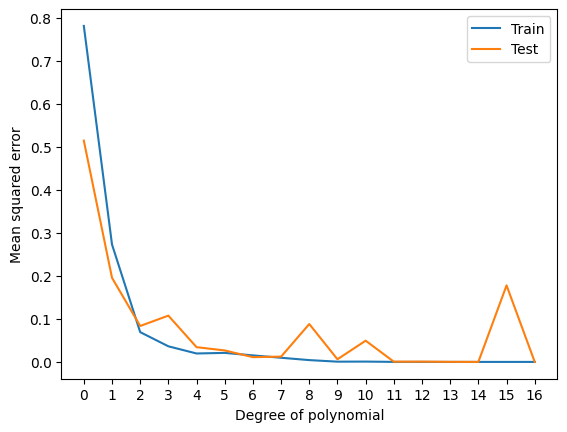

In [209]:
# Create data set
n = 30
x = np.linspace(-3, 3, n).reshape(-1, 1)
np.random.seed(RNG_SEED)
noise = np.random.normal(0, 0.01, x.shape)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + noise

maxdegree = 17
degrees = np.arange(maxdegree)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)

# Create design matrix 
X = np.zeros((n, maxdegree))
for degree in degrees:
    X[:, degree] = x[:, 0]**degree

# Then loop over the degrees again to do the mean error calculations
for degree in degrees:
    # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X[:, :degree], y, test_size=0.2)
    
    # OLS regression
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    y_tilde = X_train @ beta
    y_predict = X_test @ beta
    
    # Store MSE vals
    train_mse[degree] = MSE(y_train, y_tilde)
    test_mse[degree] = MSE(y_test, y_predict)

# Plotting
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.xlabel("Degree of polynomial")
plt.ylabel("Mean squared error")  
plt.xticks(degrees)
plt.savefig(FIGURES_DIR / "part_e_bias_variance_hastie.png")

Now plot franke function as a function of polynomial degree:

In [219]:
# GLOBAL PARAMETERS
N = 500  # number of data points
n_bootstraps = 300  # no. bootstrap resamples
noise_std = 1  # standard deviation for noise

# Create data set
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

# Get franke function with noise
np.random.seed(RNG_SEED)
noise = np.random.normal(0, noise_std, x.shape)
z = FrankeFunction(x, y) + noise

# Initialize scaler
scaler = StandardScaler()

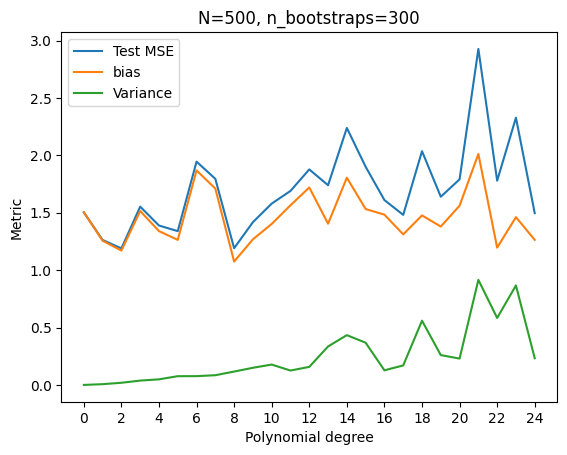

In [221]:
######### BIAS-VARIANCE AS FUNCTION OF POLY. DEGREE #############
# PARAMETERS
maxdegree = 25  # max polynomial degree for plotting

# Init arrays
degrees = np.arange(0, maxdegree, 1)
mse_arr = np.empty(degrees.shape)
bias_arr = np.empty_like(mse_arr)
var_arr = np.empty_like(mse_arr)

# Iterate through all the different polynomial degrees
for degree in degrees:
    # Create design matrix X
    X = create_X(x, y, n=degree)  # intercept included

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    
    # Fix shapes
    z_test = z_test.reshape(z_test.shape[0], 1)
    
    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Bootstrap resampling
    z_predict = np.empty((z_test.shape[0], n_bootstraps))
    for i in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        
        # OLS regression
        beta = np.linalg.pinv(X_.T @ X_) @ X_.T @ z_
        z_predict[:, i] = X_test_scaled @ beta
        
    # Store the MSE, bias, and variance
    mse_arr[degree] = MSE_bootstrap(z_test, z_predict)
    bias_arr[degree] = bias_bootstrap(z_test, z_predict)
    var_arr[degree] = variance_bootstrap(z_predict)
    
plt.plot(degrees, mse_arr, label='Test MSE')
plt.plot(degrees, bias_arr, label='bias')
plt.plot(degrees, var_arr, label='Variance')
plt.xlabel("Polynomial degree")
plt.ylabel("Metric")
plt.title(f"{N=}, {n_bootstraps=}")
plt.xticks(range(0, maxdegree, 2))
plt.legend()
plt.savefig(FIGURES_DIR / "part_e_mse_polydeg.png")